## Deep Learning PA4
## Ahmed Anwar 20110236
All parts done  
Assignment completed on Google Colab

[Google Drive Link](https://drive.google.com/drive/folders/1222DWdry01wlSrp2S6TIupnsSvDjlQZO?usp=sharing)

# Cross-View Image Retrieval (CVIR)

In this part, we'll be implementing a Cross-View Image Retrieval System. You have probably heard about Content Based Image Retrieval Systems (CBIR) where we have a database of images and given a query image, we will return similar images based on their features (Basically, Google Image Search). CVIR is a more complex problem, where your query image will have a different *view* and you will search for similar images in a different view which contain the same semantic information. For instance, you may have a satellite image of a river, and when you pass this in a CVIR, it should return images of rivers taken from the ground-level view (or street view).

Here's an overview of the system we will be implementing in this assignment:

- **Feature Extraction**: In this component, we will train a CNN that will extract useful features of a query image. We will use transfer learning to fine-tune a VGG16 model.    
- **Similarity Matching**: This is the core of our system. Here we will find the similarity between the feature vector extracted from the query image, and the feature vectors of search images, and assign similarity scores. We will perform this for each image in the database and store their scores.     
- **Retrieval**: Once we have scores for each query image, we will sort these results based on the similarity scores, with the most similar (i.e. has the smallest distance) being on the top, and the least similar (i.e. has the largest distance) being at the bottom. Finally we will return the retrieved images.

### IMPORTANT: Enter your Roll Number in the cell below

In [1]:
ROLLNUMBER = 20110236

NUM_CLASSES = 6
labels_dict = {"freeway":0,"mountain":1,"palace":2,"river":3,"ship":4,"stadium":5}

# Batch size is a hyperparameter, feel free to change this. You may also change the number of epochs.
BATCH_SIZE = 32
EPOCHS = 5

%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import keras
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from keras.applications import VGG16
from keras.layers import Flatten, Dense, Dropout, LeakyReLU, Input, concatenate, add, Reshape, Conv2D, Activation
from keras.optimizers import Adam, RMSprop, Adagrad, SGD
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical, plot_model
from glob import glob
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import resize
import collections
import os
from scipy.spatial.distance import cosine
from tensorflow.keras.preprocessing.image import ImageDataGenerator as ImageDataGenerator
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import seaborn as sns

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Task 1 - Loading Data
You have been provided with Images from two different views: Street (Ground Level) and Satellite. Each of these views contain images of 6 classes: Freeway, Mountain, River, Ship, Stadium, and Palace. We know you guys loved creating Data Generators, but for this task we will be using built-in Image Generators in TensorFlow. <br> 

Additionally, we can also augment data in real-time using these generators. Data Augmentation is an important technique of generalizing your models even more for unseen data. We can augment Image data by manipulating it, which keeps all the semantic information but can essentially be treated as new data. For instance, we can rotate, flip, zoom-in an Image and this image will be treated as a new data point in addition to our current dataset.

**IMPORTANT: You may augment data, but that would mean running a lot of epochs to train your models, since we have not trained our models on augmented data**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
cd drive/My\ Drive/DeepLearning/PA4

/content/drive/My Drive/DeepLearning/PA4


### Using Built-In Data Generator
First, we will create ImageDataGenerator objects, which allows you to add methods to augment data in real-time as well as pre-process it. Read the documentation to get a good grip of it: [Image Pre-processing](https://keras.io/preprocessing/image/#imagedatagenerator-class)

Create an ImageDataGenerator object for training and only set the validation_split argument. (If you want to augment data and train your model for more epochs, you may add arguments for augmenting data)

In [0]:
train_aug = ImageDataGenerator(validation_split = 0.20)

Now, create data generators (Train and Validation for **EACH** view) using the flow_from_directory method of the ImageDataGenerator object. Pass in the appropriate arguments.     
**IMPORTANT:**
 - Target size should be (224,224).
 - For the training generators pass in subset='training' in flow_from_directory and similarly for the validation generators, pass in subset='validation'.
 - Also pass in seed=ROLLNUMBER

In [195]:
## SATELLITE VIEW ##
train_generator_sat = train_aug.flow_from_directory(
        'SatView/Images',
        target_size=(224, 224),
        subset = 'training',
        batch_size=BATCH_SIZE,
        seed = ROLLNUMBER
        )

validation_generator_sat = train_aug.flow_from_directory(
        'SatView/Images',
        target_size=(224, 224),
        subset = 'validation',
        batch_size=BATCH_SIZE,
        seed = ROLLNUMBER
        )

Found 3360 images belonging to 6 classes.
Found 840 images belonging to 6 classes.


In [196]:
## STREET VIEW ##
train_generator_str = train_aug.flow_from_directory(
        'StreetView/Images',
        target_size=(224, 224),
        subset = 'training',
        batch_size = BATCH_SIZE,
        seed = ROLLNUMBER
        )

validation_generator_str = train_aug.flow_from_directory(
        'StreetView/Images',
        target_size=(224, 224),
        subset = 'validation',
        batch_size = BATCH_SIZE,
        seed = ROLLNUMBER
        )

Found 4271 images belonging to 6 classes.
Found 1064 images belonging to 6 classes.


Feel free to explore the attributes and methods in the data generator created above. Some important ones are: filepaths (Returns a list of all files found in the specified directory), n (Number of files, this will be useful when passing in the steps_per_epoch argument in fit_generator), labels (Labels corresponding to the filepaths)

## Task 2 - Classification Models
In order to extract discriminative features, we will imply transfer learning and use VGG16 (pre-trained on ImageNet) models to fine-tune them for our purpose. These models will be used to perform image classification for images in each view. We will be training a separate model for each view.

### Create an Instance of a pre-trained VGG16 Model
We'll create an instance of a VGG16 model (pre-trained on Imagenet) that is available in the Keras Applications module. Refer to the applications module to learn more about using pre-trained models: [Keras Applications](https://keras.io/applications/).

When we create an instance of a pre-trained model, we set include_top to False, which will remove all Dense layers from the "head" of the model. We do this since we want to use the model for, say a 10-class classification task instead of ImageNet's 1000-class task. For the weights, we will pass in 'imagenet' since we want to utilize features learned from the ImageNet dataset. Lastly, we can define the input_shape that our model should expect, i.e. (224,224,3) in our case since we will be resizing images to match the input shape of VGG16.

In [0]:
base_model_sat = VGG16(weights='imagenet', include_top=False, input_shape = (224,224,3))
base_model_str = VGG16(weights='imagenet', include_top=False, input_shape = (224,224,3))

In [0]:
base_model_sat.name = "sat_base_model"
base_model_str.name = "str_base_model"

### Adding additional layers to fine-tune the model
 When we want to use transfer learning to fine-tune a model trained on a problem similar to ours, we tweak the "head" of the model to meet our requirements. The models loaded above have no dense layers, so we will add a couple of dense layers and **TRAIN ONLY THOSE DENSE LAYERS** while <strong>*freezing*</strong> all other layers. We will include the following layers to our base VGG16 models:
 
 - Flatten
 - Dense layer with 1024 units and ReLu activation
 - Dropout with parameter 0.4
 - Dense layer with 1024 units and ReLu activation
 - Dropout with parameter 0.5
 - Dense layer with NUM_CLASSES and softmax activation

Using the Functional API of Keras, add the aforementioned layers to both models.     
**Note: For the Flatten layer, the input will be the output of the last layer of the base model, i.e. base_model.output.**

In [0]:
# Add layers to your Satellite Base Model
sat = base_model_sat.output
sat = Flatten()(sat)
sat = Dense(1024, activation='relu')(sat)
sat = Dropout(rate =0.4)(sat)
sat = Dense(1024, activation='relu')(sat)
sat = Dropout(rate =0.5)(sat)
output_sat = Dense(NUM_CLASSES,activation='softmax')(sat)

In [0]:
# Add layers to your Street Base Model
street = base_model_str.output
street = Flatten()(street)
street = Dense(1024, activation='relu',name='dense_1')(street)
street = Dropout(rate=0.4)(street)
street = Dense(1024, activation='relu',name = 'dense_2')(street)
street = Dropout(rate=0.5)(street)
output_street = Dense(NUM_CLASSES,activation='softmax')(street)

Now, create new Models using the Model constructor

In [0]:
sat_classification_model = Model(inputs = base_model_sat.input, outputs = output_sat, name = 'sat_classification_model')
str_classification_model = Model(inputs = base_model_str.input, outputs = output_street, name = 'str_classification_model')

View the model summary for each model and verify if your model is correct

In [0]:
sat_classification_model.summary()

Model: "sat_classification_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56

In [0]:
str_classification_model.summary()

Model: "str_classification_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56

Before we compile our classification models, we need to *freeze* the layers of our **base_models**. If we don't do this then we will be retraining the VGG16 model and we don't want that because: 1) The filters that the pre-trained VGG16 has learned on ImageNet are most probably already very good in terms of finding features of images, so we usually don't need to re-train these layers 2) Our machines will probably die.

In order to freeze these layers, we will iterate over base_model.layers and for each layer L we will freeze it by setting L.trainable to False. Do this for both models below

In [0]:
# Freeze layers for BOTH models
for L in base_model_sat.layers:
  L.trainable = False

for L in base_model_str.layers:
  L.trainable = False

Now, we can compile our models. You already know how to do this (Hopefully)

In [0]:
# Compile
sat_classification_model.compile(loss= 'categorical_crossentropy', optimizer = Adam(lr = 0.0001), metrics = ['accuracy'])
str_classification_model.compile(loss= 'categorical_crossentropy', optimizer = Adam(lr = 0.0001), metrics = ['accuracy'])

### Training the Classification Model
Your favourite part. Model.fit and that's about it.

Add any callbacks you want to here (I would recommend adding at least the ModelCheckpoint so you can resume training)

**Note:** For Carrying out training in intervals you can save your best models to disk and then stop your training. Whenever you wish to resume your training, you can load this model using load_model, and then call fit_generator on it. <br> In fit_generator, you will need to pass in initial_epoch as well in order to retain epoch-dependent objects such as optimizers, which will be the epoch number of the model you loaded. Secondly, you will need to set epochs relative to this initial_epoch. For instance, if your loaded model corresponds to epoch 10, and you want to train your model for 10 epochs, you will pass in initial_epoch=10 and epochs=20, not 10, since your model has already been trained for 10 epochs, and you want to train it for 10 more epochs.

In [0]:
# Callbacks for Satellite Model
mc = ModelCheckpoint('Sat_best_model.h5', monitor='val_loss', mode='min', save_best_only=True, verbose = 1)
sat_calls = [mc]

In [0]:
# Callbacks for Street Model
mc = ModelCheckpoint('Str_best_model.h5', monitor='val_loss', mode='min', save_best_only=True, verbose = 1)
str_calls = [mc]

In order to give you a head start we've already trained the models for you for some epochs yielding decent validation accuracy. Load these **weights** using model.load_weights

In [0]:
# Load weights for BOTH models
sat_classification_model.load_weights('sat_weights')
sat_classification_model.load_weights('str_weights')

Train it for a couple of more epochs (At least 1-2). You may reduce the batch_size if memory is an issue for you. Additionally, check out the workers and use_multiprocessing arguments of fit_generator to speed up training.

In [0]:
#load best model
sat_classification_model = load_model('Sat_best_model.h5')
str_classification_model = load_model('Str_best_model.h5')

In [212]:
sat_hist = sat_classification_model.fit_generator(
           generator = train_generator_sat,
           steps_per_epoch = len(train_generator_sat)//BATCH_SIZE,
           epochs = EPOCHS,
           validation_data = validation_generator_sat,
           validation_steps = len(validation_generator_sat)//BATCH_SIZE,
           use_multiprocessing = True, 
           verbose = 1, 
           callbacks = sat_calls) 

Epoch 1/5
3/3 [==============================] - 456s 152s/step - loss: 4.1918 - acc: 0.5938 - val_loss: 1.3169 - val_acc: 0.8202

Epoch 00001: val_loss did not improve from 1.25439
Epoch 2/5
3/3 [==============================] - 454s 151s/step - loss: 2.9917 - acc: 0.6875 - val_loss: 1.2479 - val_acc: 0.8357

Epoch 00002: val_loss improved from 1.25439 to 1.24792, saving model to Sat_best_model.h5
Epoch 3/5
3/3 [==============================] - 434s 145s/step - loss: 2.8563 - acc: 0.6667 - val_loss: 1.0800 - val_acc: 0.8500

Epoch 00003: val_loss improved from 1.24792 to 1.08001, saving model to Sat_best_model.h5
Epoch 4/5
3/3 [==============================] - 405s 135s/step - loss: 2.3668 - acc: 0.7188 - val_loss: 1.0194 - val_acc: 0.8631

Epoch 00004: val_loss improved from 1.08001 to 1.01937, saving model to Sat_best_model.h5
Epoch 5/5
3/3 [==============================] - 393s 131s/step - loss: 2.4877 - acc: 0.7188 - val_loss: 1.0467 - val_acc: 0.8560

Epoch 00005: val_loss di

In [228]:
str_hist = str_classification_model.fit_generator(
           generator = train_generator_str,
           steps_per_epoch = len(train_generator_str)//BATCH_SIZE,
           epochs = EPOCHS,
           validation_data = validation_generator_str,
           validation_steps = len(validation_generator_str)//BATCH_SIZE,
           use_multiprocessing = True, 
           callbacks = str_calls) 

Epoch 1/5
4/4 [==============================] - 111s 28s/step - loss: 2.1457 - acc: 0.8359 - val_loss: 0.9002 - val_acc: 0.9062

Epoch 00001: val_loss did not improve from 0.33451
Epoch 2/5
4/4 [==============================] - 80s 20s/step - loss: 2.4740 - acc: 0.7891 - val_loss: 0.7070 - val_acc: 0.9062

Epoch 00002: val_loss did not improve from 0.33451
Epoch 3/5
4/4 [==============================] - 78s 20s/step - loss: 1.7765 - acc: 0.8047 - val_loss: 0.8204 - val_acc: 0.8750

Epoch 00003: val_loss did not improve from 0.33451
Epoch 4/5
4/4 [==============================] - 76s 19s/step - loss: 1.6314 - acc: 0.8516 - val_loss: 0.5041 - val_acc: 0.9688

Epoch 00004: val_loss did not improve from 0.33451
Epoch 5/5
4/4 [==============================] - 77s 19s/step - loss: 1.3248 - acc: 0.8984 - val_loss: 1.1740 - val_acc: 0.8750

Epoch 00005: val_loss did not improve from 0.33451


### Model Analysis
The part you probably dread the most.

In [0]:
def plot_accuracy(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

Plot losses and accuracies for both models.

##### Satellite Model

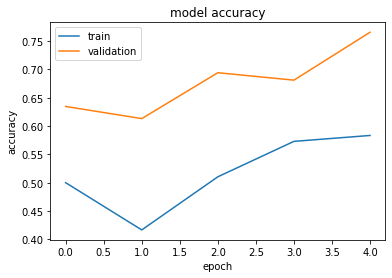

In [0]:
#plot from earlier
plot_accuracy(sat_hist)

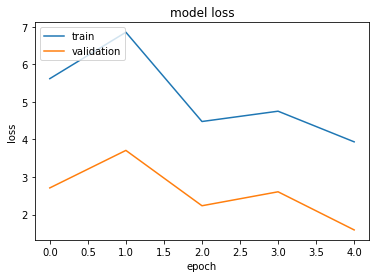

In [0]:
plot_loss(sat_hist)

##### Street Model

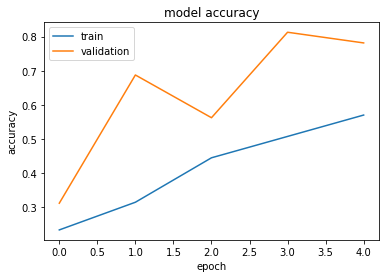

In [0]:
plot_accuracy(str_hist)

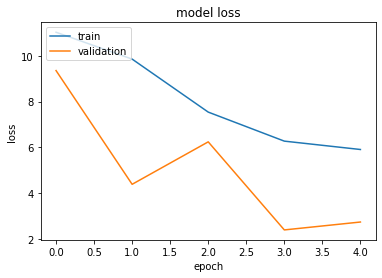

In [0]:
plot_loss(str_hist)

Q) You may observe that your validation metrics are better than your training metrics. Explain how this is possible? <br>
Answer:   
The model contains a dropout layer for regularization which turns off some layer inputs. However, this is turned off at testing time. So all features are used and the model is more robust at testing time, thus resulting in higher accuracy.    
A second reason could be that, training loss is average of the losses over each batch of training data. During training, our model is changing over time and the loss of the first batches of epoch is generally higher than over the last batches. When this is averaged it results in a higher overall loss. On the other hand, testing/validation loss for an epoch is computed using the model as it is at the end of an epoch, thus resulting in a lower loss.



#### Confusion Matrix
For each model, evaluate the model on the validation set (using the val_generators) then compute and print the confusion matrix. Pick appropriate evaluation metrics for a typical classification task and then comment on these metrics while justifying your reason for choosing these metrics (e.g. Talking about Precision and why precision is important etc.). Also, check and comment if your model is confused between some classes and explain why do you think that confusion lies in your opinion.
<br> Use Sci-kit Learn to compute the confusion matrix and plot it.

In [0]:
from sklearn.metrics import precision_recall_fscore_support
def plot_confusion_matrix(conf_mat):
    classes = ['freeway', 'mountain', 'palace', 'river', 'ship', 'stadium']
    df_cm = pd.DataFrame(conf_mat,classes,classes)
    plt.figure(figsize=(10,7))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})
    #plt.show()

Analysis 
1. Precision measures, how many of predicted positives are actually positive. In our case, it will be how many of the predicted labels of a particular class are actually of that class. 
2. Recall measures how many of the acutal (true labels) are classified as positive by the model. In multi-label classification, this means how many of actual labels of a prticular class are correctily predicted by our model. This metris is important when there is high cost of false negative. For instance,  in sick patient detection. If a sick patient (Actual Positive) goes through the test and predicted as not sick (Predicted Negative). The cost associated with False Negative will be extremely high if the sickness is contagious 
3. There is usually a tradeoff between precision and recall. To cater to this F1 score is calculated which is the simple harmonic mean of precision and recall. 

For this model i would choose F1 score as it incorporates both precision and recall. 

###### Satellite

In [0]:
best_sat = load_model('Sat_best_model.h5')

In [221]:
# Evaluation Metrics and Confusion Matrix for the satellite model
sat_model_predictions = best_sat.predict_generator(validation_generator_sat,use_multiprocessing = True, verbose = 1).argmax(axis=1)
true_labels = validation_generator_sat.labels

cm_sat = confusion_matrix(true_labels,sat_model_predictions)
Eval_sat = precision_recall_fscore_support(true_labels, sat_model_predictions, average = 'macro')

27/27 [==============================] - 337s 12s/step


Precision :  0.183
Recall :  0.183
F1-score :  0.183


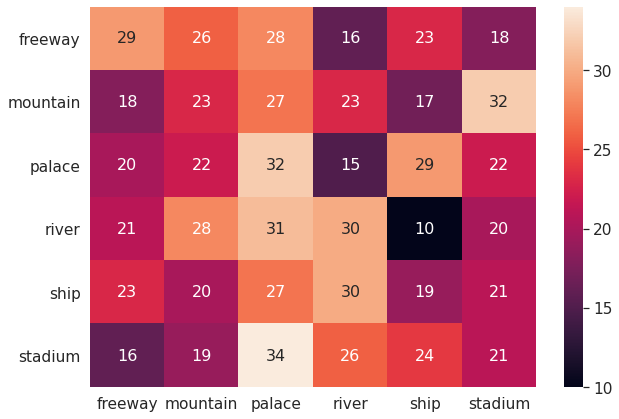

In [224]:
print('Precision : ', round(Eval_sat[0],3))
print('Recall : ', round(Eval_sat[1],3))
print('F1-score : ', round(Eval_sat[2],3))
plot_confusion_matrix(cm_sat)

I am assuming that predicted labels are annotated on the left and actual labels are annotated on the bottom.

Ideally the scores on the diagonal (True Positives) should be as high as possible and scores other than the diagonals should be low.

However, in this model there is notable conusion between labels such as 
1. stadium and palace
2. palace and mountain
3. river and freeway
4. ship and river

Firstly, i believe that the model has been trained on 5 epochs only which has resulted in a lower accuracy. If the model is allowed to train with higher epochs, accuracy will improve and this confusion will go away. 
Secondly, i think that features of these labels are more or less similar which cause tis confusion. 

###### Street

In [0]:
best_str = load_model('Str_best_model.h5')

In [226]:
# Evaluation Metrics and Confusion Matrix for the street model
str_model_predictions = best_str.predict_generator(validation_generator_str,use_multiprocessing = True, verbose = 1).argmax(axis=1)
true_labels = validation_generator_str.labels

cm_str = confusion_matrix(true_labels,str_model_predictions)
Eval_str = precision_recall_fscore_support(true_labels, str_model_predictions, average = 'macro')

34/34 [==============================] - 497s 15s/step


Precision :  0.168
Recall :  0.168
F1-score :  0.167


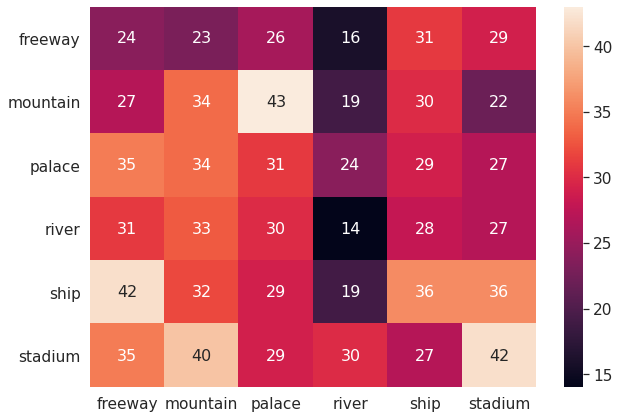

In [227]:
cm_str = confusion_matrix(true_labels,str_model_predictions)
Eval_str = precision_recall_fscore_support(true_labels, str_model_predictions, average = 'macro')

print('Precision : ', round(Eval_str[0],3))
print('Recall : ', round(Eval_str[1],3))
print('F1-score : ', round(Eval_str[2],3))

plot_confusion_matrix(cm_str)

Confusion exist between:
1. ship and freeway
2. mountain and palace

## Task 3 - Similarity Matching
This is the core of our CVIR system, where feature vectors of query images and search images will be compared and assigned a similarity score (or distance between these two vectors). We will be using the following distance metrics in order to compute similarity (distance is opposite of similarity,lower distance means more similar):

- Cosine
- DML

### Distance Metric Learning (DML)
Just like cosine, euclidean, and other metrics to compute distances between two feature vectors, we can create a Neural Network that can compute a distance metric for us given two input feature vectors. We will train a DML, (More about this: [ICONIP-CVIR](https://www.researchgate.net/publication/337862425_Cross-View_Image_Retrieval_-_Ground_to_Aerial_Image_Retrieval_Through_Deep_Learning)) which will take two feature vectors as input and output a label: 0 (Match, i.e. 0 distance between them) or 1 (No match, i.e. completely dissimilar feature vectors). The output layer of this DML will have a sigmoid activation and will output a continuous value between 0 and 1 which will be treated as the distance between these two feature vectors.

We're providing you with the Model Architecture, use this to create a Keras model using the Functional API:     
![DML](DML_Structure1.png)

In [0]:
def DML():
  Input1 = Input(shape=(1024,1), name = 'Input_3')
  Reshape1 = Reshape((32,32,1),name = 'Reshape_3')(Input1)
  Input2 = Input(shape=(1024,1), name = 'Input_4')
  Reshape2 = Reshape((32,32,1), name = 'Reshape_4')(Input2)

  Concat2 = concatenate([Reshape1, Reshape2], name = 'Concatenate_2')

  Conv_7 = Conv2D(16, kernel_size= (3,3), padding = 'same',name = 'Conv2D_7')(Concat2)
  Conv_8 = Conv2D(16, kernel_size= (3,3), padding = 'same', name = 'Conv2D_8')(Conv_7)
  Conv_9 = Conv2D(16, kernel_size= (3,3), padding = 'same', name = 'Conv2D_9')(Conv_8)
  Add_3 = add([Conv_7,Conv_9], name = 'Add_3')

  Conv_11 = Conv2D(16,kernel_size= (3,3), strides= 2, padding = 'same', name = 'Conv2D_11')(Add_3)
  Conv_12 = Conv2D(16,kernel_size= (3,3), padding = 'same', name = 'Conv2D_12')(Conv_11)

  Conv_10 = Conv2D(16,kernel_size= (3,3), strides = 2, padding = 'same', name = 'Conv2D_10')(Add_3)
  Add_4 = add([Conv_10, Conv_12], name = 'Add_4')

  X = LeakyReLU(name = 'LeakyRelu_5')(Add_4)
  X = Flatten(name = 'Flatten_2')(X)
  X = Dense(1024,name = 'Dense_5')(X)
  X = LeakyReLU(name = 'LeakyRelu_6')(X)
  X = Dense(512,name = 'Dense_6')(X)
  X = LeakyReLU(name = 'LeakyRelu_7')(X)
  X = Dense(64, name = 'Dense_7')(X)
  X = LeakyReLU(name = 'LeakyRelu_8')(X)
  X = Dense(1, name = 'Dense_8')(X)

  activation_2 = Activation('sigmoid',name = 'activation_2')(X)
  
  My_model = Model(inputs = [Input1, Input2], outputs = activation_2, name = 'DML')

  return My_model

In [0]:
dml = DML()

In [7]:
dml.summary()

Model: "DML"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_3 (InputLayer)            (None, 1024, 1)      0                                            
__________________________________________________________________________________________________
Input_4 (InputLayer)            (None, 1024, 1)      0                                            
__________________________________________________________________________________________________
Reshape_3 (Reshape)             (None, 32, 32, 1)    0           Input_3[0][0]                    
__________________________________________________________________________________________________
Reshape_4 (Reshape)             (None, 32, 32, 1)    0           Input_4[0][0]                    
________________________________________________________________________________________________

#### Training the DML
We'll be providing you with DataFrames that contain the Train and Test data. You will realize that it is very useful to know how to create data generators when you want to yield data in a custom format. Use the DataFrame provided to create a generator and train your model. When yielding data be careful about your structure. The DML expects two inputs, so your generator should yield in this format: <br>  ( [ Satellite Feature Vector, Street Feature Vector ] ,Label )

Load the DataFrames

In [0]:
dml_train_df = pd.read_csv('dml_train.csv')
dml_test_df = pd.read_csv('dml_test.csv')

**IMPORTANT**: Training the DML can take very long considering the overhead (Loading image, Passing it in the Feature Vector Extraction model to get the feature vector, yielding this Feature Vector in the generator).    
In order to speed up training and reduce this overhead, we can perform the training in two passes:

1) Use Feature Vector Extraction Models to extract feature vectors and store this feature vectors to disk.  
2) Create a Data Generator that loads yields these feature vectors to train the DML

We have already performed step 1 for you using the pre-trained weights provided to you. The features of each image are stored in the Features/ directory. The paths are already included in the dataframes provided to you.

Q: How would you extract feature vectors from your classification models if we treat the output of the last 1024 dense layer as the Feature Vector of an Image? Write a code snippet that creates a model (Using either sat/str classification model) that takes an Image as an input and outputs its feature vector. Print this model's summary

In [0]:
# Answer - Write your code in this cell
last_dense = sat_classification_model.get_layer('dense_2').output
fv_extractor = Model(inputs = sat_classification_model.inputs, output = last_dense, name = 'FV Extractor')
fv_extractor.summary()

Model: "FV Extractor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., name="FV Extractor", outputs=Tensor("de...)`
  


**Note**: If you want to use your trained model to recompute features and train the DML on your own feature vectors, you're free to do that. Run the function below but it will take very long to compute the features. You can optimize this function by carrying computations in batches if you want to.

In [0]:
def compute_features():
    sat_imgs = glob('SatView/Images/**/*')
    str_imgs = glob('StreetView/Images/**/*')
    
    if not os.path.exists('SatView/Features'):
        os.mkdir('SatView/Features')
    if not os.path.exists('StreetView/Features'):
        os.mkdir('StreetView/Features')
    print("Computing for Satellite Images")
    for f in sat_imgs:
        img = get_image(f)
        base_path = 'SatView/Features/'
        filename = f.split('/')[-1].split('.')[0]
        ext = '.npy'
        fv = sat_fv_extractor.predict(np.expand_dims(img,axis=0)).reshape(1024,1)
        save_at = base_path + filename + ext
        if not os.path.exists(save_at):
            np.save(save_at,fv)
            
    print("Computing for Street Images")
    for f in str_imgs:
        img = get_image(f)
        base_path = 'StreetView/Features/'
        filename = f.split('/')[-1].split('.')[0]
        ext = '.npy'
        fv = str_fv_extractor.predict(np.expand_dims(img,axis=0)).reshape(1024,1)
        save_at = base_path + filename + ext
        if not os.path.exists(save_at):
            np.save(save_at,fv)

Create a Data Generator for training the DML

In [0]:
def dml_data_generator(df, batch_size = 32, mode='train'):
    
    indexes = np.arange(0,len(df),batch_size) #setting start index of each batch
    
    if len(dml_train_df) % batch_size != 0:
      indexes = indexes[:-1]  #dropping last index if last batch does not complete the batch size requirement
    
    while True:
      np.random.shuffle(indexes) #shuffles indexes so order of data given to model in each loop is different
      for index in indexes:
        batch_examples = df.iloc[index : index + batch_size].reset_index()
        
        img_shape = (1024,1)
        fv_sat = np.zeros((batch_size,*img_shape))
        fv_str = np.zeros((batch_size,*img_shape))
        labs = np.zeros(batch_size, dtype = int)
        
        for index, row in batch_examples.iterrows():
          Sat = np.load(row[1])
          Str = np.load(row[2])

          fv_sat[index,:,:] = Sat
          fv_str[index,:,:] = Str
          labs[index] = row[3]
        
        yield ([fv_sat, fv_str], labs)
 

In [0]:
dml_train_gen = dml_data_generator(dml_train_df,batch_size=BATCH_SIZE)
dml_test_gen = dml_data_generator(dml_test_df,batch_size=BATCH_SIZE)

Add any callbacks you want to

In [0]:
# Callbacks for DML go her
dml.compile(loss= 'binary_crossentropy', optimizer = Adam(lr = 0.001), metrics = ['accuracy'])

epoch_steps  = (len(dml_train_df) // BATCH_SIZE ) // BATCH_SIZE
val_steps  = (len(dml_test_df) // BATCH_SIZE ) // BATCH_SIZE

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True, verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose =1)

In [160]:
dml_hist = dml.fit_generator(dml_train_gen, epochs= 50, steps_per_epoch = epoch_steps, 
                            validation_data = dml_test_gen, use_multiprocessing=True, verbose = 1,
                            callbacks = [mc,es],
                            validation_steps= val_steps)

Epoch 1/50
32/32 [==============================] - 12s 369ms/step - loss: 0.2124 - acc: 0.9121 - val_loss: 0.1708 - val_acc: 0.9336

Epoch 00001: val_loss did not improve from 0.15280
Epoch 2/50
32/32 [==============================] - 9s 280ms/step - loss: 0.2620 - acc: 0.8936 - val_loss: 0.3372 - val_acc: 0.8750

Epoch 00002: val_loss did not improve from 0.15280
Epoch 3/50
32/32 [==============================] - 9s 284ms/step - loss: 0.2476 - acc: 0.8926 - val_loss: 0.3367 - val_acc: 0.8672

Epoch 00003: val_loss did not improve from 0.15280
Epoch 4/50
32/32 [==============================] - 9s 287ms/step - loss: 0.2813 - acc: 0.8877 - val_loss: 0.2196 - val_acc: 0.9141

Epoch 00004: val_loss did not improve from 0.15280
Epoch 5/50
32/32 [==============================] - 9s 285ms/step - loss: 0.2538 - acc: 0.8945 - val_loss: 0.3067 - val_acc: 0.8672

Epoch 00005: val_loss did not improve from 0.15280
Epoch 6/50
32/32 [==============================] - 9s 284ms/step - loss: 0.226

Now, train the DML model on the provided dataset. You are free to tweak the hyperparameters of this model. Unlike the previous assignment, the accuracy of your DML will matter when grading your assignment. You can try different optimizers, learning rates, and if you want to, you can tweak the DML model as well but the overall structure should remain the same.

###### Plot DML Accuracy and Loss

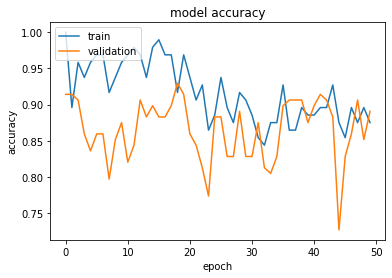

In [132]:
plot_accuracy(dml_hist)

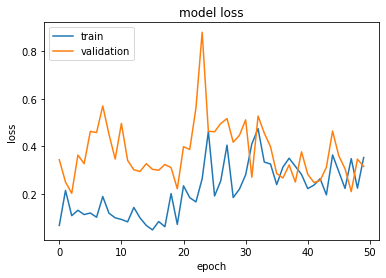

In [133]:
plot_loss(dml_hist)

Q) Comment on your DML model's bias and variance. <br>
Answer: Bias is also low, as the model is performing well on training set. It is not underfitting the data.  
Variance is low as the model performs well on validation data since its accuracy is significant on validation set. 

### Computing Similarity between Query Image and a Search Image

In [0]:
def sort_by_value(dict_obj):
    return collections.OrderedDict(sorted(dict_obj.items(), key=lambda kv: kv[1]))

Create a function that takes in a query image's Feature Vector (Or its path more precisely, a real system takes in a image but for our purposes we'll use feature vectors to speed up retrieval), and a Database which contains images their view and class labels (This will be provided to you). In this function you need to:    
* Load the Feature Vector of the Query Image  
* For each image OF THE OPPOSITE VIEW in the database:   
  1.  Load the feature vector of the search image  
  2.  Get a distance score based on the metric argument  
  3.  Store the result  
  4.  Store all results in a Python Dictionary in which the keys are the paths to retrieved images, and values are the distance scores.
* Return the sorted results dictionary (Use the sort_by_value function)

**IMPORTANT:** When passing in inputs to the DML in predict, you need to reshape your reshape your Feature Vector to (1,1024,1). It's the same as saying that you're passing in data with a batch_size of 1. You can predict in batches but then you will also need to figure out how to store the results in the final sorted dictionary.

The get_similar function will expect a DataFrame (Database arugment) that stores information about the images in our database, you don't have to worry about this since we will provide you with this DataFrame.

In [0]:
# Load your best DML Model here
dml = load_model('best_model.h5')

In [166]:
dml.evaluate_generator(dml_test_gen,use_multiprocessing=True, steps = 32)

[0.24981172336265445, 0.9013671875]

In [0]:
def get_similar(query_fv_path,database, metric,query_view='str',batch_size=32):
    results = dict()
    fv_query = np.load(query_fv_path).reshape(1,1024,1)

    if query_view == 'sat':
        db = database[database['view'] == 'str'].reset_index()
    elif query_view == 'str':
        db = database[database['view'] == 'sat'].reset_index()
    
    for i in range(len(db)):
      fv_search = np.load(db['fv_path'][i]).reshape(1,1024,1)
      img_path = db['img_path'][i]

      if metric == 'dml':
        score = dml.predict([fv_search,fv_query])[0][0]
      else:
        score = cosine(fv_query, fv_search)
      
      results[img_path] = score

    return sort_by_value(results)

## Task 4 - Image Retrieval
Now its time to put it all together and run our CVIR system.

In [0]:
def view_results(results_dict,n=5):
    fig = figure(figsize=(15,15))
    files = list(results_dict.keys())
    for i in range(n):
        a=fig.add_subplot(1,n,i+1)
        image = imread(files[i])
        imshow(image)
        axis('off')

In [0]:
def get_db(df,imgs_per_classes=5):
    classes = ['freeway','mountain','palace','river','ship', 'stadium']
    sat_df = df[df['view'] == 'sat']
    str_df = df[df['view'] == 'str']
    db = pd.DataFrame({},columns=df.columns)
    for c in classes:
        sat_sample = sat_df[sat_df['class'] == c].sample(imgs_per_classes,random_state=ROLLNUMBER)
        str_sample = str_df[str_df['class'] == c].sample(imgs_per_classes,random_state=ROLLNUMBER)
        db = pd.concat([db,sat_sample,str_sample])
    return db.sample(frac=1,random_state=ROLLNUMBER).reset_index(drop=True)

In [0]:
full_database = pd.read_csv('Retrieval_Database.csv')

In [0]:
database = get_db(full_database,imgs_per_classes=5)
#database

Finally, put all functions together to perform a search. We will be using **Street View Images as our queries** <br>
For **EACH** class, pick one query image from the database provided to you, and then search for its results. **You also need to perform these searches for BOTH metrics (Cosine and DML)** and then analyze and comment on each metric's performance. Try and see if you can find queries/classes for which your system does not perform well.

In [0]:
def search(query_fv_path,database,dist_metric,num_results=5):
    results = get_similar(query_fv_path,database,dist_metric)
    top_n = list(results.items())[0:num_results]
    top_n_dict = sort_by_value(dict(top_n))

    return top_n_dict

### Retrievals

##### Using Cosine Distance

query for : stadium


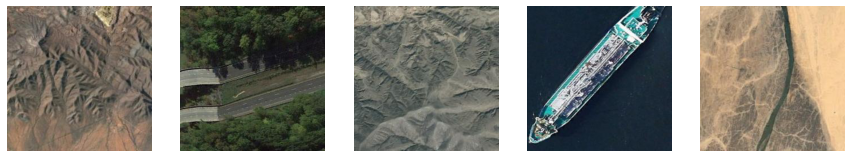

In [111]:
lookup = database['fv_path'][12]
print('query for :', database['class'][12])
res = search(lookup,database,'cosine')
view_results(res)

query for : palace


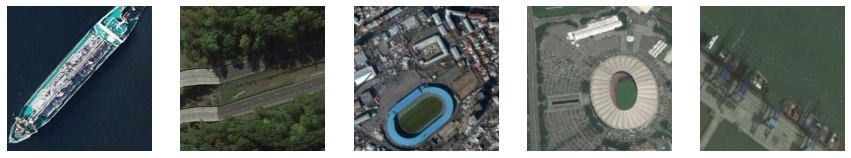

In [0]:
lookup = database['fv_path'][9]
print('query for :',database['class'][9])
res = search(lookup,database,'cosine')
view_results(res)

query for : freeway


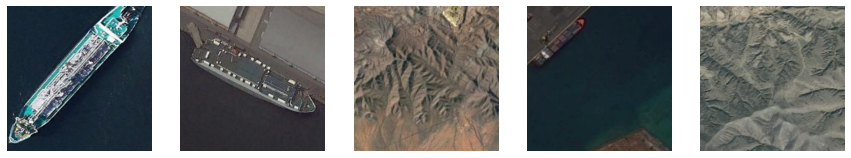

In [0]:
lookup = database['fv_path'][5]
print('query for :',database['class'][5])
res = search(lookup,database,'cosine')
view_results(res)

query for : ship


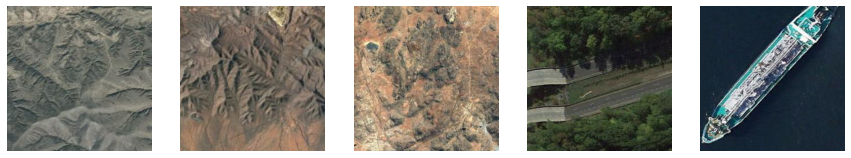

In [0]:
lookup = database['fv_path'][6]
print('query for :',database['class'][6])
res = search(lookup,database,'cosine')
view_results(res)

query for : river


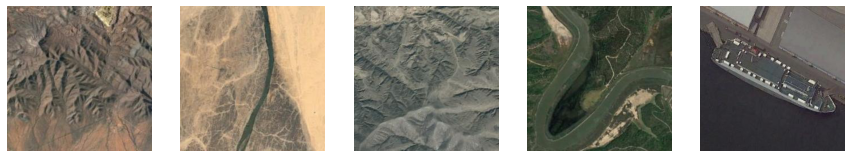

In [0]:
lookup = database['fv_path'][7]
print('query for :',database['class'][7])
res = search(lookup,database,'cosine')
view_results(res)

query for : mountain


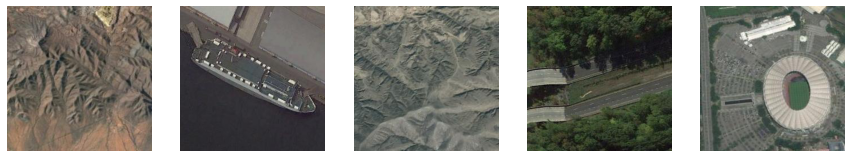

In [0]:
lookup = database['fv_path'][10]
print('query for :',database['class'][10])
res = search(lookup,database,'cosine')
view_results(res)

##### Using the DML

query for : stadium


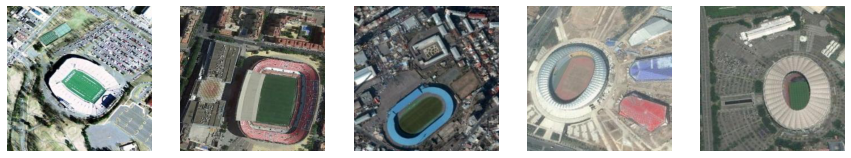

In [154]:
lookup = database['fv_path'][12]
print('query for :',database['class'][12])
res = search(lookup,database,'dml')
view_results(res)

query for : palace


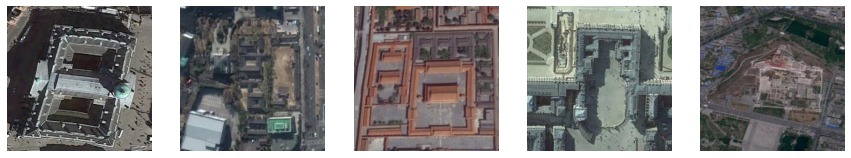

In [155]:
lookup = database['fv_path'][9]
print('query for :',database['class'][9])
res = search(lookup,database,'dml')
view_results(res)

query for : freeway


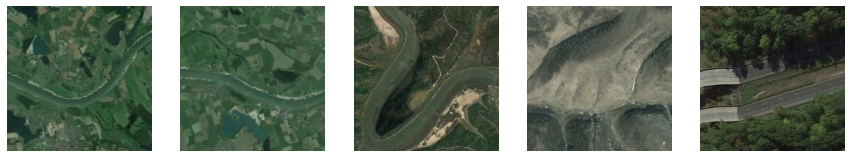

In [156]:
lookup = database['fv_path'][5]
print('query for :',database['class'][5])
res = search(lookup,database, 'dml')
view_results(res)

query for : ship


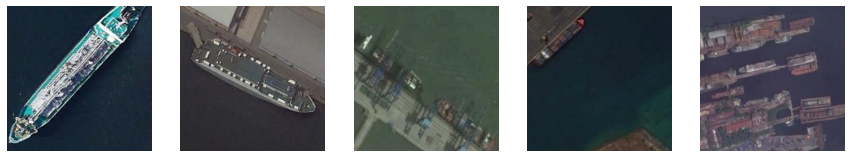

In [157]:
lookup = database['fv_path'][6]
print('query for :',database['class'][6])
res = search(lookup,database, 'dml')
view_results(res)

query for : river


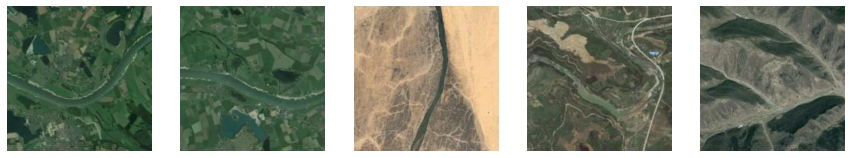

In [174]:
lookup = database['fv_path'][39]
print('query for :',database['class'][39])
res = search(lookup,database,'dml')
view_results(res)

query for : mountain


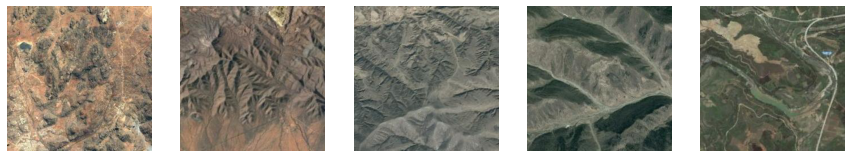

In [159]:
lookup = database['fv_path'][10]
print('query for :',database['class'][10])
res = search(lookup,database,'dml')
view_results(res)

#### Analysis
Write your analysis here and show any visualisations you want to here.

DML performs signifcantly better than Cosine model. My model had accuracy of around 95% and it gave almost perfect results